In [8]:
#Covariance 3x2 + cluster version - Dec 1st 2019
# NxN, NxCls (gg, gk, kk) 
# Incorporates Photo-z uncertainties and mass-richness relationship
# mass integral taken outside (assuming average redshift within bin)
# units now checked 
# Limber approximation added to check Ncl and Ncl
# Limber assuming for C-ells (l)
# using 2FAST algorithm to tackle double bessel integrals 
# using approximation formula from Assassi, Simonovic and Zaldarriaga paper to overcome Hypergeometric function of a complex argument
# assuming full sky for now
# Included shot noise (1-halo term)
# Added full matrix in the end 
# Fixed shot noise (no bias)
# Added np.argwhere for interpolation
# *****************************************************************

#import necessary modules for our computation
import numpy as np
import time
from scipy.integrate import romb, quad  #this will be necessary for some integrals
from scipy.special import gamma #this will import spherical bessel functions, gamma and Gauss Hypergeometric function
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pyccl as ccl #import CCL python wrapper 
import pickle, pprint

In [9]:
#Setup initial cosmology and Make a ccl class. We will later vary them for MCMC
Omg_c = 0.26
Omg_b = 0.04
h0 = 0.67 #so H0 = 100h0 will be in km/s/Mpc
A_s_value = 2.1e-9
n_s_value = 0.96
w_0 = -1.
w_a = 0.0
overdensity_delta = 200
c = 299792.458 # in km/s

survey_area = 4*np.pi #assuming full sky for now

cosmo = ccl.Cosmology(Omega_c = Omg_c, 
                      Omega_b = Omg_b, 
                      h = h0, 
                      A_s = A_s_value, 
                      n_s = n_s_value, 
                      w0 = w_0, wa = w_a)

In [10]:
#Define arrays for bins for Photometric z and Z grid
Zmin = 0.3
Zmax = 1.2
Z_bin_range = 0.05
Num_z_bins = round((Zmax-Zmin)/Z_bin_range)
Z_bins = np.round(np.linspace(Zmin,Zmax,Num_z_bins+1),2)
print(Z_bins, Num_z_bins)
print("Minimum radial distance is " + str(ccl.comoving_radial_distance(cosmo, 1/(1+Z_bins[0])))+ " Mpc")
print("Maximum radial distance is " + str(ccl.comoving_radial_distance(cosmo, 1/(1+Z_bins[Num_z_bins])))+ " Mpc")

[0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95
 1.   1.05 1.1  1.15 1.2 ] 18
Minimum radial distance is 1247.8400578373084 Mpc
Maximum radial distance is 3931.479845283442 Mpc


In [12]:
# insert function that calculates Photo z, given true redshift z_true and photometric bin z_i
def photoz(z_true, z_i): 
    sigma_z = 0.05*(1+z_true)
    integrand = lambda z_phot: np.exp(- (z_phot - z_true)**2. / (2.*sigma_z**2.))/ (np.sqrt(2.*np.pi) * sigma_z)
    return (quad(integrand,Z_bins[z_i], Z_bins[z_i+1])[0]/(1.-quad(integrand, -np.inf, 0.)[0]))
# Notice that I am truncating the pdf, so as to absorb the negative redshifts into the positive part of the pdf

Lim_z_min = max(0.02, Z_bins[0]-4*Z_bin_range) #minimum z_true for the integrals. I am assuming z_true>0.02 
Lim_z_max = Z_bins[-1]+6*Z_bin_range #maximum z_true for the integrals, assuming 40% larger than max z, so we dont need to go till infinity

Lim_R_min = ccl.comoving_radial_distance(cosmo, 1/(1+Lim_z_min))
Lim_R_max = ccl.comoving_radial_distance(cosmo, 1/(1+Lim_z_max))

print(Lim_z_min, Lim_R_min)
print(Lim_z_max, Lim_R_max)

0.09999999999999998 437.18704239759813
1.5 4558.602004298992


In [13]:
#define function for dv1 = comoving volume per steridian as function of z_true for a photometric redshift bin; dv(z) = dz*dr/dz(z)*(r(z)**2)*photoz(z, bin z_i)
          
def dV(z_true, z_i): #output will be in Mpc**3
    return c*(ccl.comoving_radial_distance(cosmo, 1/(1+z_true))**2)/(100*h0*ccl.h_over_h0(cosmo,1/(1+z_true)))*(photoz(z_true, z_i))
   

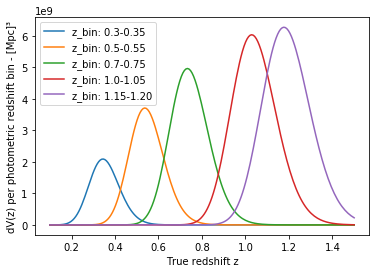

In [8]:
#Plotting how dV varies with Z_true for different Z-bins
testx = np.linspace(Lim_z_min, Lim_z_max, 200)
testy1 = [dV(testx[m], 0) for m in range (200)]
testy2 = [dV(testx[m], 4) for m in range (200)]
testy3 = [dV(testx[m], 8) for m in range (200)]
testy4 = [dV(testx[m], 14) for m in range (200)]
testy5 = [dV(testx[m], 17) for m in range (200)]
plt.plot(testx, testy1, label = "z_bin: 0.3-0.35")
plt.plot(testx, testy2, label = "z_bin: 0.5-0.55")
plt.plot(testx, testy3, label = "z_bin: 0.7-0.75")
plt.plot(testx, testy4, label = "z_bin: 1.0-1.05")
plt.plot(testx, testy5, label = "z_bin: 1.15-1.20")
plt.xlabel("True redshift z")
plt.ylabel ("dV(z) per photometric redshift bin - [Mpc]³")
plt.legend()
plt.show()

In [14]:
# define logarithmically-spaced richness bins 
Lbdmin = 10
Lbdmax = 100
Lbd_bin_range = 30
Num_Lbd_bins = round((Lbdmax-Lbdmin)/Lbd_bin_range)
Lbd_bins = np.round(np.logspace(np.log10(Lbdmin),np.log10(Lbdmax),Num_Lbd_bins+1),2)
print(Lbd_bins, Num_Lbd_bins)

[ 10.    21.54  46.42 100.  ] 3


In [15]:
# Define lognormal mass-richness relation (leveraging paper from Murata et. alli - ArxIv 1707.01907 and Costanzi et all ArxIv 1810.09456v1)
A = 3.207 #Murata
B = 0.75 #Costanzi
sigma_zero = 2.68 # Costanzi
q = 0.54 # # Costanzi
M_pivot = 3.e+14/h0 #in solar masses , Murata and Costanzi use it 

#Function that returns the probability that the true mass ln(M_true) is observed within the bins lambda_i and lambda_i + 1 
def mass_richness (Ln_M_true, lbd_i): 
    sigma_lambda = sigma_zero+q*(Ln_M_true-np.log(M_pivot))
    average = A+B*(Ln_M_true-np.log(M_pivot))
    integrand = lambda lbd: (1./lbd)*np.exp(- (np.log(lbd)-average)**2. / (2.*sigma_lambda**2.))/ (np.sqrt(2.*np.pi) * sigma_lambda)
    return (quad(integrand,Lbd_bins[lbd_i], Lbd_bins[lbd_i+1])[0])

Mmin = np.log(1.e+13) #minimum log mass in solar masses; below this the probability is almost nill
Mmax = np.log(1.e+16) #maximum log mass in solar masses; above this the halo mass function is below 10^⁻10

# just testing which percentage is obtained for the minimum and maximum masses within the richness limits
test_min = [mass_richness(Mmin, i) for i in range(Num_Lbd_bins)]
print(np.sum(test_min))
print(ccl.massfunc(cosmo, np.exp(Mmax), 1/(1+Lim_z_min), overdensity=overdensity_delta))

0.0009528852621284171
1.3009749580368971e-11


In [16]:
# define integral that calculates the response of nh to variations in background density 
def integral_mass (z, lbd_i): #z is the redshift; i is the lambda bin,with lambda from Lambda_bins[i] to Lambda_bins[i+1]
    f = lambda ln_m:(1/np.log(10))*ccl.massfunc(cosmo, np.exp(ln_m),1/(1+z),overdensity = overdensity_delta)*ccl.halo_bias(cosmo, np.exp(ln_m),1/(1+z),overdensity = overdensity_delta)*mass_richness(ln_m, lbd_i)
    #Remember ccl.function returns dn/dlog10m, I am changing integrand to d(lnM)
    return quad(f, Mmin, Mmax)[0]

# showing that the integral varies slowly within a redshift bin , but for higher z and higher lbd error can be big...  
for i in range (Num_Lbd_bins):
    for z_i in range (Num_z_bins):
        print ("For redshift bin: " + str(z_i) + " and richness bin: " + str(i))
        print(integral_mass(Z_bins[z_i],i), integral_mass(Z_bins[z_i+1], i))
        print("\n")
  

For redshift bin: 0 and richness bin: 0
2.5575931064257202e-05 2.575929737275998e-05


For redshift bin: 1 and richness bin: 0
2.575929737275998e-05 2.588568797984225e-05


For redshift bin: 2 and richness bin: 0
2.588568797984225e-05 2.595234791870173e-05


For redshift bin: 3 and richness bin: 0
2.595234791870173e-05 2.5957183727383228e-05


For redshift bin: 4 and richness bin: 0
2.5957183727383228e-05 2.589879561340047e-05


For redshift bin: 5 and richness bin: 0
2.589879561340047e-05 2.5776493645559717e-05


For redshift bin: 6 and richness bin: 0
2.5776493645559717e-05 2.5590298467914603e-05


For redshift bin: 7 and richness bin: 0
2.5590298467914603e-05 2.5340927691185577e-05


For redshift bin: 8 and richness bin: 0
2.5340927691185577e-05 2.502976840498566e-05


For redshift bin: 9 and richness bin: 0
2.502976840498566e-05 2.4658839558434906e-05


For redshift bin: 10 and richness bin: 0
2.4658839558434906e-05 2.4230743188827645e-05


For redshift bin: 11 and richness bin: 0


In [17]:
def integral_mass_no_bias (z,lbd_i):
    f = lambda ln_m:(1/np.log(10))*ccl.massfunc(cosmo, np.exp(ln_m),1/(1+z),overdensity = overdensity_delta)*mass_richness(ln_m, lbd_i)
    #Remember ccl.function returns dn/dlog10m, I am changing integrand to d(lnM)
    return quad(f, Mmin, Mmax)[0]


In [18]:
#Calculating the shot noise term
def shot_noise (z_i,lbd_i):
    integrand = lambda z: c*(ccl.comoving_radial_distance(cosmo, 1/(1+z))**2)/(100*h0*ccl.h_over_h0(cosmo,1/(1+z)))*integral_mass_no_bias(z, lbd_i)*photoz(z, z_i)
    result = quad(integrand, Lim_z_min, Lim_z_max)
    return survey_area*result[0]
# testing with one 
print(shot_noise(0,0))
        

63973.112093743934


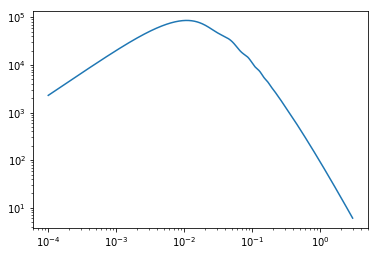

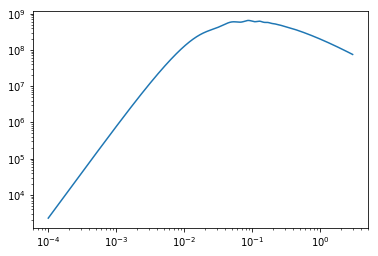

2293.8187696736672 74686413.61445285


In [19]:
# Prepare r array and k array for 2-FAST
#Define main parameters
ko = 1.e-4
kmax = 3
ro = 1/kmax
rmax = 1/ko
G = np.log(kmax/ko)
N = 1024
L = 2*np.pi*N/G
k_vec = np.logspace(np.log(ko), np.log(kmax), N, base = np.exp(1))
r_vec = np.logspace(np.log(ro), np.log(rmax), N, base = np.exp(1))
bias_fft = 1.4165
pk_vec = ccl.linear_matter_power(cosmo, k_vec, 1)
fk_vec = (k_vec/ko)**(3.-bias_fft)*pk_vec # this is the function to be fftlog-ed 
plt.loglog(k_vec, pk_vec)
plt.show()
plt.loglog(k_vec, fk_vec)
plt.show()
print(fk_vec[0], fk_vec[-1])

In [20]:
# Performing the FFT of the fk_vec function, leveraging the fact it is real
Phi_vec = np.conjugate(np.fft.rfft(fk_vec))/L

In [21]:
#Calculating the function M_0_0
def I_ell (m, R): #the formula below only valid for R <=1, l = 0,  formula B2 ASZ and 31 from 2-fast paper 
    t_m = 2*np.pi*m/G
    alpha_m = bias_fft-1.j*t_m
    pre_factor =(ko*ro)**(-alpha_m)
    if R<1:
        return pre_factor*0.5*np.cos(np.pi*alpha_m/2)*gamma(alpha_m-2)*(1/R)*((1+R)**(2-alpha_m)-(1-R)**(2-alpha_m))
    elif R==1:
        return pre_factor*0.5*np.cos(np.pi*alpha_m/2)*gamma(alpha_m-2)*((1+R)**(2-alpha_m))
    

In [26]:
#this range includes the Min and  Max limits of the integrals, with a +- safery factor of 5
Index_min = np.int(np.argwhere(r_vec>Lim_R_min)[0]-5)
Index_max = np.int(np.argwhere(r_vec<Lim_R_max)[-1]+5)
print(Index_min,Index_max)

708 950


In [27]:
# function that calculates the double bessel integral from I-ell algorithm, as function of z1 and z2
def double_bessel_integral (z1,z2):
    r2 = ccl.comoving_radial_distance(cosmo, 1/(1+z2))
    r1 = ccl.comoving_radial_distance(cosmo, 1/(1+z1))
    R = min(r1, r2)/max(r1, r2) #definition of t, forcing it to be <= 1
    I_ell_vec = [I_ell(m,R) for m in range(N//2+1)]
    back_FFT_vec = np.fft.irfft(Phi_vec*I_ell_vec)*N # FFT back
    two_fast_vec = (1/np.pi)*(ko**3)*((r_vec/ro)**(-bias_fft))*back_FFT_vec/G
    f = interp1d(r_vec[Index_min:Index_max],two_fast_vec[Index_min:Index_max], kind = 'cubic') #we will use this to interpolate the exact r(z1)
    return f(max(r1, r2))
    
    
    

In [28]:
#checking that sigma decreases over z 
for i in range (Num_z_bins+1):
    print(double_bessel_integral(Z_bins[i],Z_bins[i]), Z_bins[i])






8.427201923802976e-05 0.3
6.488992629242469e-05 0.35
5.2176984919593145e-05 0.4
4.336791824883875e-05 0.45
3.699935594513981e-05 0.5
3.223660216832832e-05 0.55
2.857493826683163e-05 0.6
2.5694321563601472e-05 0.65
2.3383652663647597e-05 0.7
2.14990198479607e-05 0.75
1.9939512346958536e-05 0.8
1.86326342444278e-05 0.85
1.7525178350702492e-05 0.9
1.657736444572024e-05 0.95
1.5758949055510335e-05 1.0
1.5046596177453623e-05 1.05
1.4422060788439187e-05 1.1
1.387090776316786e-05 1.15
1.3381583543908735e-05 1.2


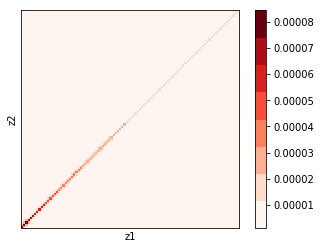

In [29]:
z1_vec = np.linspace(Z_bins[0],Z_bins[Num_z_bins],100)
z2_vec = np.linspace(Z_bins[0],Z_bins[Num_z_bins],100)
sigma_vec = np.zeros((100,100))
for i in range (100):
    for j in range (i,100):
        sigma_vec[i,j] = double_bessel_integral(z1_vec[i],z2_vec[j])
        sigma_vec [j,i] = sigma_vec[i,j]

plt.imshow(np.rot90(sigma_vec), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.yticks([])
plt.xticks([])
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()


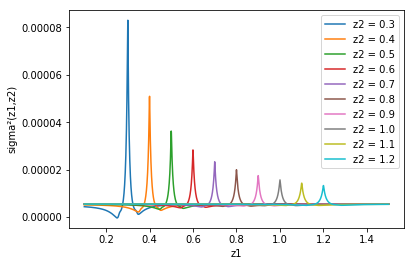

In [27]:
# Testing the routine above to check on results of the double bessel integral
npoints = 2001
z_range = np.linspace(Lim_z_min, Lim_z_max, npoints)
y_plot = np.zeros((10, npoints))
for i in range(10):
        y_plot[i] = [double_bessel_integral(Z_bins[2*i], z_range[j]) for j in range (npoints)] 
        plt.plot(z_range, y_plot[i], label = "z2 = " + str(Z_bins[2*i]))
plt.xlabel("z1")
plt.ylabel("sigma²(z1,z2)")
plt.legend()
plt.show() 
       
    
   

    


In [19]:
#I did two versions, but will use partial2, based on Romberg. It is faster and more reliable
def partial(z1, bin_z_j, bin_lbd_j):
    kernel = lambda z2: dV(z2,bin_z_j)*ccl.growth_factor(cosmo, 1/(1+z2))*double_bessel_integral(z1,z2)
    return quad(kernel, Lim_z_min,Lim_z_max)[0]*integral_mass(z1,bin_lbd_j)

def partial2(z1, bin_z_j, bin_lbd_j):
    romb_k = 5
    if (z1<=np.average(Z_bins)):    
        vec_left = np.linspace(max(Lim_z_min, z1-6*Z_bin_range),z1, 2**(romb_k-1)+1)
        vec_right = np.linspace(z1, z1+(z1-vec_left[0]),2**(romb_k-1)+1)
        vec_final = np.append(vec_left, vec_right[1:])
    else: 
        vec_right = np.linspace(z1, min(Lim_z_max, z1+6*Z_bin_range),2**(romb_k-1)+1)
        vec_left = np.linspace(z1-(vec_right[-1]-z1),z1,2**(romb_k-1)+1)
        vec_final = np.append(vec_left, vec_right[1:])
    romb_range = (vec_final[-1]-vec_final[0])/(2**romb_k)
    kernel = np.zeros(2**romb_k+1)
    for m in range(2**romb_k+1):
        kernel[m] = dV(vec_final[m],bin_z_j)*ccl.growth_factor(cosmo, 1/(1+vec_final[m]))*double_bessel_integral(z1,vec_final[m])
    return (romb(kernel, dx=romb_range))*integral_mass(z1,bin_lbd_j)#approximation, taking the integral mass outside the integral




In [20]:
# Now to finalize the last integral, I will use Romberg integration method
# We assume true value of z1 will not be far from the limits of the photometric bin, just + or - 4 times the Z_bin range
    
romb_num = 2**6+1 #Romberg integral demands this number of "z"s. With 2**4 + 1 convergence is already good
Z1_true_vec = np.zeros((Num_z_bins,romb_num))
G1_true_vec = np.zeros((Num_z_bins,romb_num))
dV_true_vec = np.zeros((Num_z_bins,romb_num))
for i in range(Num_z_bins):
    Z1_true_vec[i] = np.linspace(max(Lim_z_min, Z_bins[i]-4*Z_bin_range), min(Lim_z_max, Z_bins[i+1]+6*Z_bin_range), romb_num)
    G1_true_vec[i] = ccl.growth_factor(cosmo, 1/(1+Z1_true_vec[i]))
    dV_true_vec[i] = [dV(Z1_true_vec[i,m], i) for m in range(romb_num)]
    
print(Z1_true_vec, "\n")
print(G1_true_vec,"\n")
print(dV_true_vec, "\n")

M1_true_vec = np.zeros((Num_Lbd_bins, Num_z_bins, romb_num))
for lbd in range (Num_Lbd_bins):
    for z in range (Num_z_bins):
        for m in range(romb_num):
            M1_true_vec[lbd,z,m] = integral_mass(Z1_true_vec[z,m], lbd)
print(M1_true_vec, "\n")





[[0.1        0.10859375 0.1171875  ... 0.6328125  0.64140625 0.65      ]
 [0.15       0.15859375 0.1671875  ... 0.6828125  0.69140625 0.7       ]
 [0.2        0.20859375 0.2171875  ... 0.7328125  0.74140625 0.75      ]
 ...
 [0.85       0.85859375 0.8671875  ... 1.3828125  1.39140625 1.4       ]
 [0.9        0.90859375 0.9171875  ... 1.4328125  1.44140625 1.45      ]
 [0.95       0.95859375 0.9671875  ... 1.4828125  1.49140625 1.5       ]] 

[[0.94966513 0.94543676 0.94122518 ... 0.7243118  0.72130969 0.71832672]
 [0.92530374 0.92117662 0.9170677  ... 0.70711149 0.70421937 0.70134583]
 [0.90154989 0.89753127 0.89353189 ... 0.69054316 0.68775767 0.68499017]
 ...
 [0.65407249 0.6515229  0.64898982 ... 0.52316951 0.52144579 0.51973242]
 [0.63946784 0.63701272 0.63457345 ... 0.5132844  0.51161985 0.50996522]
 [0.6254038  0.6230394  0.62069023 ... 0.50373719 0.5021292  0.50053065]] 

[[1.14488183e+05 2.64555984e+05 5.80099542e+05 ... 4.45960132e+06
  3.28782949e+06 2.41393405e+06]
 [4.30723

In [22]:
def cov_N_N (bin_z_i, bin_z_j, bin_lbd_i, bin_lbd_j):
    dz = (Z1_true_vec[bin_z_i,-1]-Z1_true_vec[bin_z_i,0])/(romb_num-1)
    partial_vec = [partial2(Z1_true_vec[bin_z_i, m], bin_z_j, bin_lbd_j) for m in range(romb_num)]
    romb_vec = partial_vec*dV_true_vec[bin_z_i]*M1_true_vec[bin_lbd_i, bin_z_i]*G1_true_vec[bin_z_i] 
    return (survey_area**2)*romb(romb_vec, dx=dz)




In [23]:
# this will store all results using covN_N for different redshift bins and average of Limber and cov2 for similar redshift bin
final_array = np.zeros((Num_Lbd_bins, Num_Lbd_bins, Num_z_bins, Num_z_bins)) 
ini = time.time()

print("Zbin_i \tZbin_j \tLbd_i \tLbd_j \tCov \t\tDtime")

for lbd_i in range(Num_Lbd_bins):   
    for lbd_j in range(lbd_i, Num_Lbd_bins):
        for i in range (Num_z_bins):
            for j in range (i, Num_z_bins):
                start = time.time()
                if (lbd_i == lbd_j and i == j):
                    shot = shot_noise(i,lbd_i)
                else:
                    shot = 0
                final_array[lbd_i,lbd_j,i,j]= shot + cov_N_N(i,j,lbd_i,lbd_j) 
                final_array[lbd_i,lbd_j,j,i]= final_array[lbd_i,lbd_j,i,j]
                final_array[lbd_j,lbd_i,i,j]= final_array[lbd_i,lbd_j,i,j]           
                end = time.time()
                print ( "%d \t%d \t%d \t%d \t%4.3e \t%3.2f "%\
                       (i, j, lbd_i, lbd_j,float(final_array[lbd_i,lbd_j,i,j]),  (end-start))   )


                
                with  open('data/.covariance.tmp', 'wb') as fout: # save partial evaluation
                    pickle.dump(final_array, fout)
                with  open('data/.covariance_last_step.dat', 'w') as fout: # Save last step evaluated
                    fout.write("%d %d %d %d "%(lbd_i, lbd_j,i, j) )
                
                
                
with  open('data/covariance.pkl', 'wb') as fout: # save partial evaluation
    pickle.dump(final_array, fout)

print ("\ntotal elapsed matrix for matrix was: " + str((end-ini)/3600) + "hours.")

Zbin_i 	Zbin_j 	Lbd_i 	Lbd_j 	Cov 		Dtime
0 	0 	0 	0 	1.304e+05 	19.48 
0 	1 	0 	0 	7.290e+04 	17.55 
0 	2 	0 	0 	7.144e+04 	17.58 
0 	3 	0 	0 	6.581e+04 	17.47 
0 	4 	0 	0 	5.877e+04 	17.62 
0 	5 	0 	0 	5.077e+04 	17.59 
0 	6 	0 	0 	4.144e+04 	17.47 
0 	7 	0 	0 	3.106e+04 	17.43 
0 	8 	0 	0 	2.083e+04 	17.41 
0 	9 	0 	0 	1.223e+04 	17.55 
0 	10 	0 	0 	6.209e+03 	17.49 
0 	11 	0 	0 	2.712e+03 	17.55 
0 	12 	0 	0 	1.024e+03 	17.44 
0 	13 	0 	0 	3.363e+02 	17.41 
0 	14 	0 	0 	9.674e+01 	17.41 
0 	15 	0 	0 	2.437e+01 	17.46 
0 	16 	0 	0 	5.339e+00 	17.43 
0 	17 	0 	0 	1.004e+00 	17.44 
1 	1 	0 	0 	1.730e+05 	19.25 
1 	2 	0 	0 	1.040e+05 	17.37 
1 	3 	0 	0 	1.038e+05 	17.34 
1 	4 	0 	0 	9.885e+04 	17.36 
1 	5 	0 	0 	9.130e+04 	17.38 
1 	6 	0 	0 	8.078e+04 	17.41 
1 	7 	0 	0 	6.648e+04 	17.37 
1 	8 	0 	0 	4.937e+04 	17.38 
1 	9 	0 	0 	3.235e+04 	17.35 
1 	10 	0 	0 	1.848e+04 	17.38 
1 	11 	0 	0 	9.187e+03 	17.49 
1 	12 	0 	0 	3.990e+03 	18.00 
1 	13 	0 	0 	1.525e+03 	17.43 
1 	14 	0 	0 	5.1

6 	8 	0 	1 	1.427e+05 	17.16 
6 	9 	0 	1 	1.361e+05 	17.15 
6 	10 	0 	1 	1.235e+05 	17.18 
6 	11 	0 	1 	1.051e+05 	17.17 
6 	12 	0 	1 	8.275e+04 	17.14 
6 	13 	0 	1 	5.957e+04 	17.17 
6 	14 	0 	1 	3.897e+04 	17.19 
6 	15 	0 	1 	2.310e+04 	17.17 
6 	16 	0 	1 	1.241e+04 	17.15 
6 	17 	0 	1 	6.047e+03 	17.17 
7 	7 	0 	1 	1.520e+05 	17.12 
7 	8 	0 	1 	1.569e+05 	17.13 
7 	9 	0 	1 	1.552e+05 	17.12 
7 	10 	0 	1 	1.471e+05 	17.19 
7 	11 	0 	1 	1.325e+05 	17.14 
7 	12 	0 	1 	1.122e+05 	17.56 
7 	13 	0 	1 	8.814e+04 	17.24 
7 	14 	0 	1 	6.359e+04 	17.12 
7 	15 	0 	1 	4.189e+04 	17.14 
7 	16 	0 	1 	2.514e+04 	17.10 
7 	17 	0 	1 	1.373e+04 	17.19 
8 	8 	0 	1 	1.638e+05 	17.14 
8 	9 	0 	1 	1.679e+05 	17.12 
8 	10 	0 	1 	1.650e+05 	17.10 
8 	11 	0 	1 	1.554e+05 	17.08 
8 	12 	0 	1 	1.392e+05 	17.19 
8 	13 	0 	1 	1.173e+05 	17.09 
8 	14 	0 	1 	9.200e+04 	17.12 
8 	15 	0 	1 	6.654e+04 	17.11 
8 	16 	0 	1 	4.414e+04 	17.10 
8 	17 	0 	1 	2.679e+04 	17.08 
9 	9 	0 	1 	1.729e+05 	17.08 
9 	10 	0 	1 	1.7

1 	1 	1 	1 	6.400e+04 	19.32 
1 	2 	1 	1 	2.940e+04 	17.37 
1 	3 	1 	1 	2.927e+04 	17.40 
1 	4 	1 	1 	2.781e+04 	17.40 
1 	5 	1 	1 	2.563e+04 	17.39 
1 	6 	1 	1 	2.262e+04 	17.38 
1 	7 	1 	1 	1.855e+04 	17.45 
1 	8 	1 	1 	1.372e+04 	17.43 
1 	9 	1 	1 	8.947e+03 	17.36 
1 	10 	1 	1 	5.083e+03 	17.40 
1 	11 	1 	1 	2.510e+03 	17.37 
1 	12 	1 	1 	1.082e+03 	17.36 
1 	13 	1 	1 	4.104e+02 	17.37 
1 	14 	1 	1 	1.378e+02 	17.41 
1 	15 	1 	1 	4.103e+01 	17.39 
1 	16 	1 	1 	1.080e+01 	17.39 
1 	17 	1 	1 	2.493e+00 	17.35 
2 	2 	1 	1 	7.867e+04 	19.20 
2 	3 	1 	1 	3.863e+04 	17.27 
2 	4 	1 	1 	3.891e+04 	17.35 
2 	5 	1 	1 	3.765e+04 	17.29 
2 	6 	1 	1 	3.515e+04 	17.30 
2 	7 	1 	1 	3.102e+04 	17.30 
2 	8 	1 	1 	2.513e+04 	17.28 
2 	9 	1 	1 	1.823e+04 	17.31 
2 	10 	1 	1 	1.168e+04 	17.29 
2 	11 	1 	1 	6.578e+03 	17.35 
2 	12 	1 	1 	3.265e+03 	17.30 
2 	13 	1 	1 	1.434e+03 	17.34 
2 	14 	1 	1 	5.607e+02 	17.30 
2 	15 	1 	1 	1.957e+02 	17.29 
2 	16 	1 	1 	6.093e+01 	17.31 
2 	17 	1 	1 	1.686e+01 	1

7 	16 	1 	2 	6.135e+03 	17.11 
7 	17 	1 	2 	3.323e+03 	17.14 
8 	8 	1 	2 	4.080e+04 	17.17 
8 	9 	1 	2 	4.171e+04 	17.13 
8 	10 	1 	2 	4.090e+04 	17.08 
8 	11 	1 	2 	3.842e+04 	17.12 
8 	12 	1 	2 	3.430e+04 	17.08 
8 	13 	1 	2 	2.878e+04 	17.11 
8 	14 	1 	2 	2.245e+04 	17.09 
8 	15 	1 	2 	1.613e+04 	17.19 
8 	16 	1 	2 	1.062e+04 	17.14 
8 	17 	1 	2 	6.396e+03 	17.11 
9 	9 	1 	2 	4.216e+04 	17.08 
9 	10 	1 	2 	4.279e+04 	17.10 
9 	11 	1 	2 	4.171e+04 	17.09 
9 	12 	1 	2 	3.894e+04 	17.09 
9 	13 	1 	2 	3.457e+04 	17.12 
9 	14 	1 	2 	2.889e+04 	17.21 
9 	15 	1 	2 	2.250e+04 	17.09 
9 	16 	1 	2 	1.621e+04 	17.11 
9 	17 	1 	2 	1.074e+04 	17.08 
10 	10 	1 	2 	4.271e+04 	17.10 
10 	11 	1 	2 	4.306e+04 	17.08 
10 	12 	1 	2 	4.172e+04 	17.15 
10 	13 	1 	2 	3.874e+04 	17.11 
10 	14 	1 	2 	3.422e+04 	17.11 
10 	15 	1 	2 	2.850e+04 	17.07 
10 	16 	1 	2 	2.218e+04 	17.11 
10 	17 	1 	2 	1.602e+04 	17.07 
11 	11 	1 	2 	4.247e+04 	17.10 
11 	12 	1 	2 	4.256e+04 	17.11 
11 	13 	1 	2 	4.102e+04 	17.13 


Covariance matrix fixing Mass bins 0 and 0


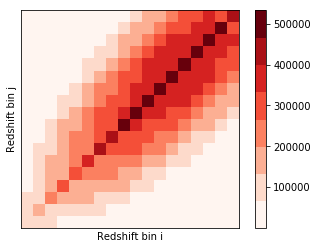

Covariance matrix fixing Mass bins 0 and 1


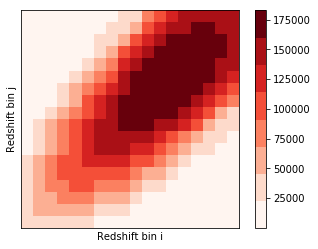

Covariance matrix fixing Mass bins 0 and 2


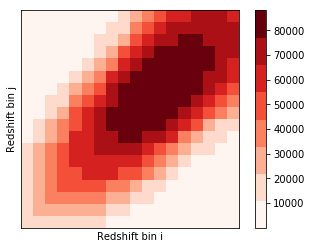

Covariance matrix fixing Mass bins 1 and 1


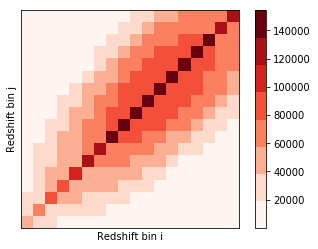

Covariance matrix fixing Mass bins 1 and 2


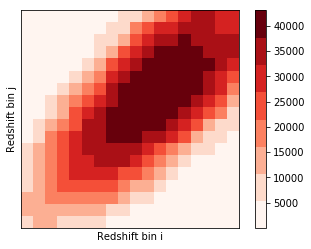

Covariance matrix fixing Mass bins 2 and 2


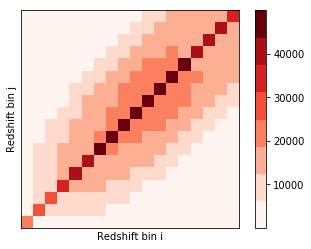

Covariance matrix fixing Z bins 0 and 0


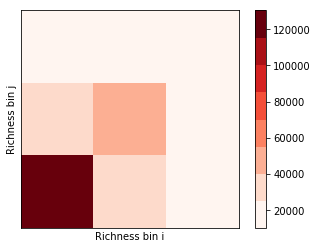

Covariance matrix fixing Z bins 0 and 1


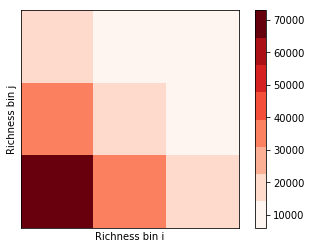

Covariance matrix fixing Z bins 0 and 2


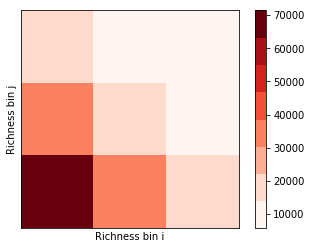

Covariance matrix fixing Z bins 0 and 3


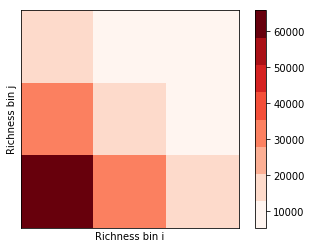

Covariance matrix fixing Z bins 0 and 4


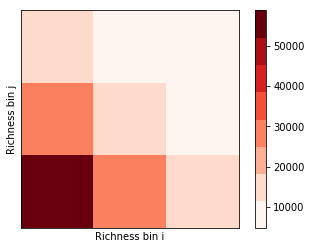

Covariance matrix fixing Z bins 0 and 5


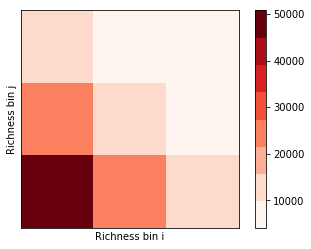

Covariance matrix fixing Z bins 0 and 6


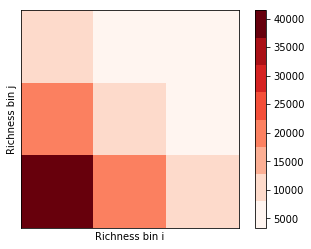

Covariance matrix fixing Z bins 0 and 7


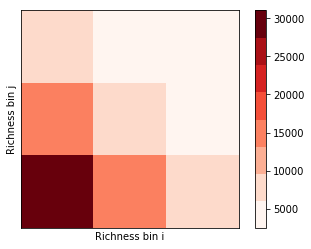

Covariance matrix fixing Z bins 0 and 8


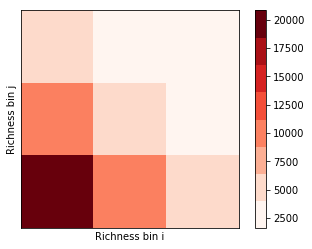

Covariance matrix fixing Z bins 0 and 9


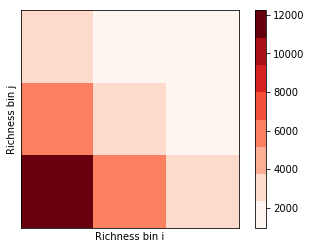

Covariance matrix fixing Z bins 0 and 10


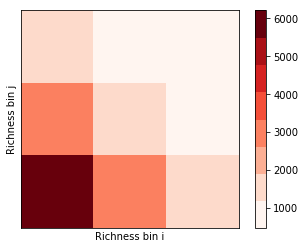

Covariance matrix fixing Z bins 0 and 11


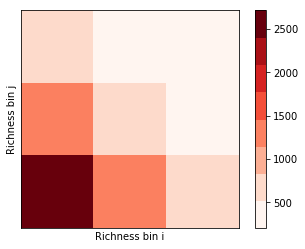

Covariance matrix fixing Z bins 0 and 12


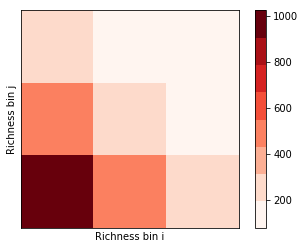

Covariance matrix fixing Z bins 0 and 13


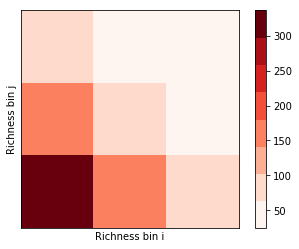

Covariance matrix fixing Z bins 0 and 14


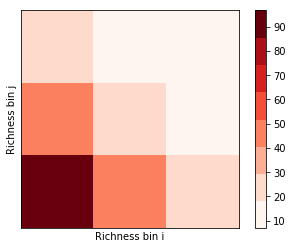

Covariance matrix fixing Z bins 0 and 15


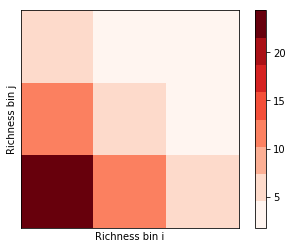

Covariance matrix fixing Z bins 0 and 16


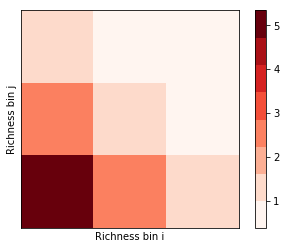

Covariance matrix fixing Z bins 0 and 17


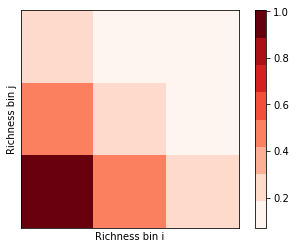

Covariance matrix fixing Z bins 1 and 1


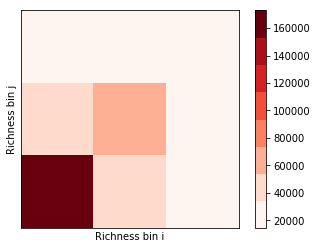

Covariance matrix fixing Z bins 1 and 2


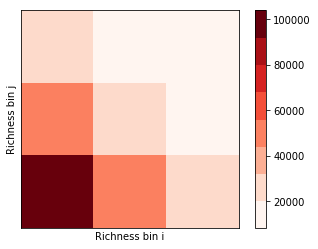

Covariance matrix fixing Z bins 1 and 3


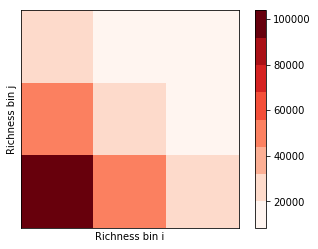

Covariance matrix fixing Z bins 1 and 4


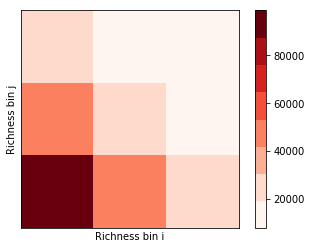

Covariance matrix fixing Z bins 1 and 5


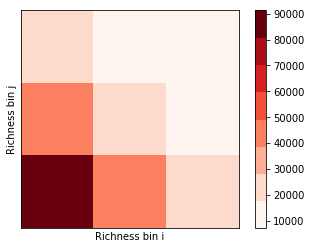

Covariance matrix fixing Z bins 1 and 6


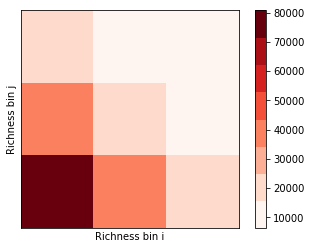

Covariance matrix fixing Z bins 1 and 7


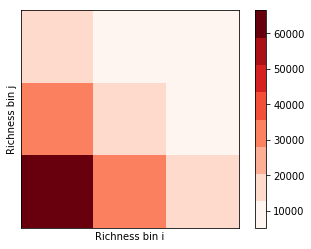

Covariance matrix fixing Z bins 1 and 8


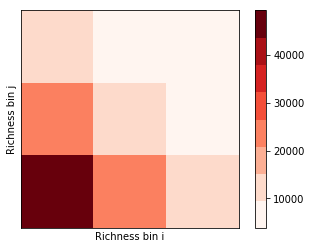

Covariance matrix fixing Z bins 1 and 9


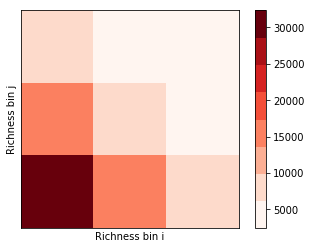

Covariance matrix fixing Z bins 1 and 10


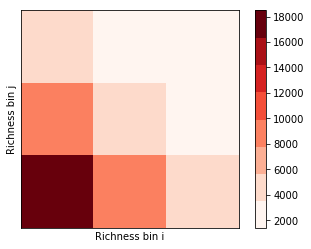

Covariance matrix fixing Z bins 1 and 11


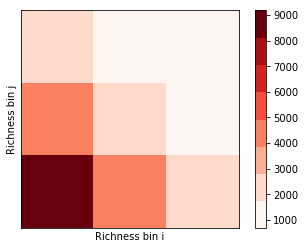

Covariance matrix fixing Z bins 1 and 12


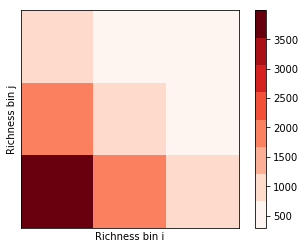

Covariance matrix fixing Z bins 1 and 13


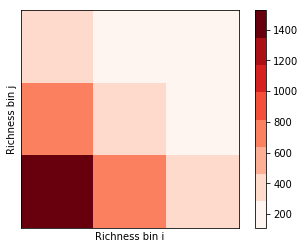

Covariance matrix fixing Z bins 1 and 14


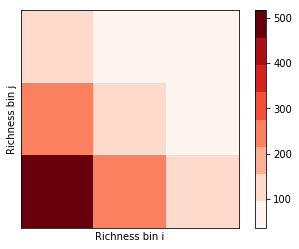

Covariance matrix fixing Z bins 1 and 15


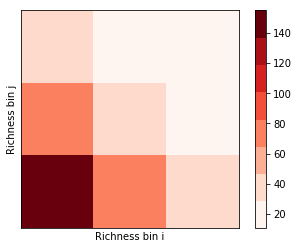

Covariance matrix fixing Z bins 1 and 16


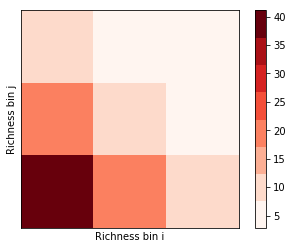

Covariance matrix fixing Z bins 1 and 17


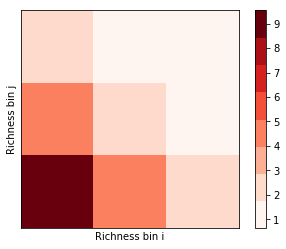

Covariance matrix fixing Z bins 2 and 2


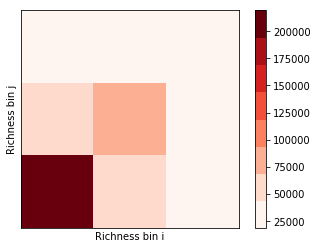

Covariance matrix fixing Z bins 2 and 3


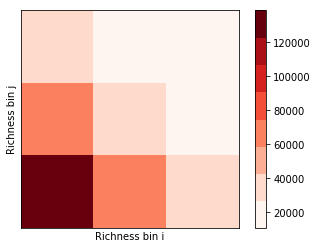

Covariance matrix fixing Z bins 2 and 4


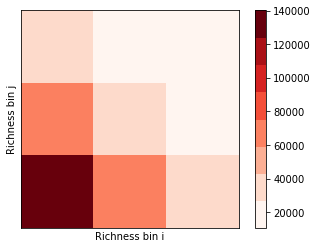

Covariance matrix fixing Z bins 2 and 5


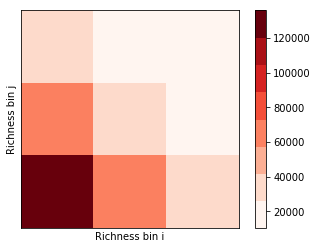

Covariance matrix fixing Z bins 2 and 6


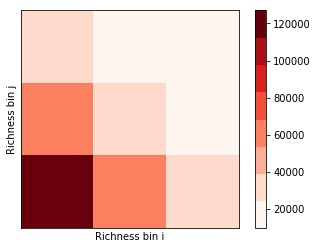

Covariance matrix fixing Z bins 2 and 7


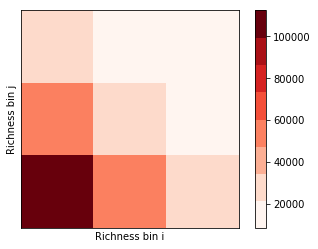

Covariance matrix fixing Z bins 2 and 8


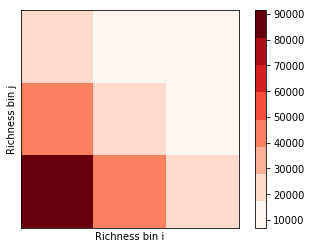

Covariance matrix fixing Z bins 2 and 9


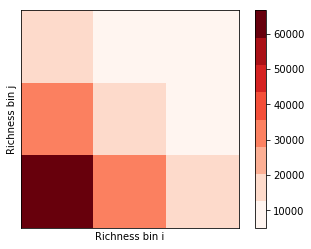

Covariance matrix fixing Z bins 2 and 10


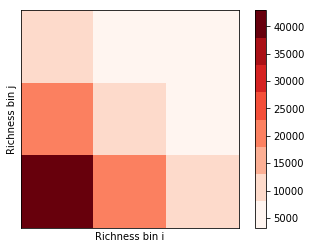

Covariance matrix fixing Z bins 2 and 11


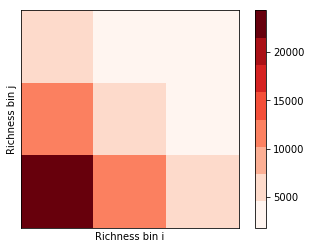

Covariance matrix fixing Z bins 2 and 12


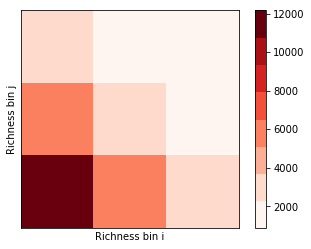

Covariance matrix fixing Z bins 2 and 13


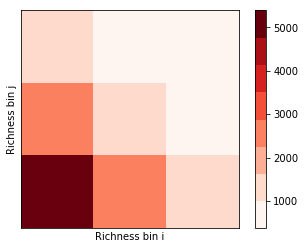

Covariance matrix fixing Z bins 2 and 14


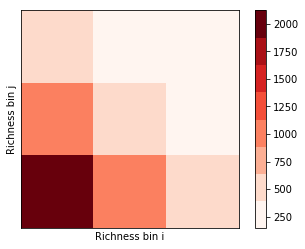

Covariance matrix fixing Z bins 2 and 15


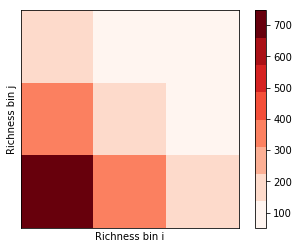

Covariance matrix fixing Z bins 2 and 16


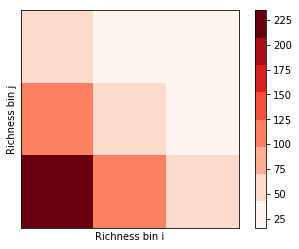

Covariance matrix fixing Z bins 2 and 17


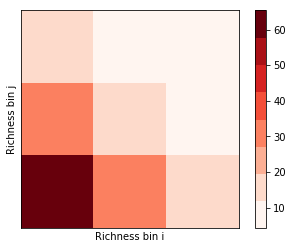

Covariance matrix fixing Z bins 3 and 3


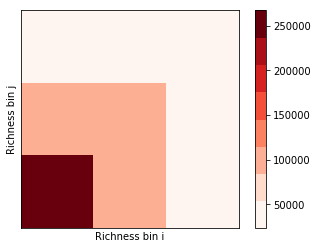

Covariance matrix fixing Z bins 3 and 4


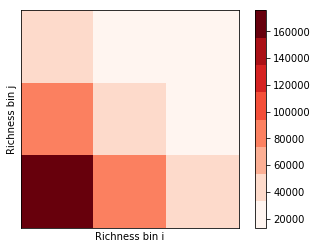

Covariance matrix fixing Z bins 3 and 5


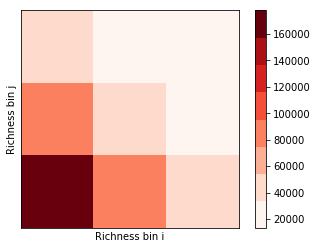

Covariance matrix fixing Z bins 3 and 6


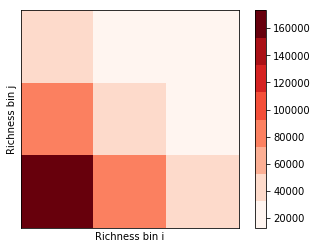

Covariance matrix fixing Z bins 3 and 7


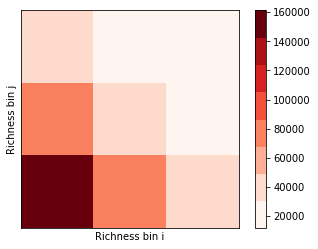

Covariance matrix fixing Z bins 3 and 8


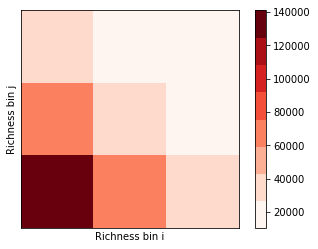

Covariance matrix fixing Z bins 3 and 9


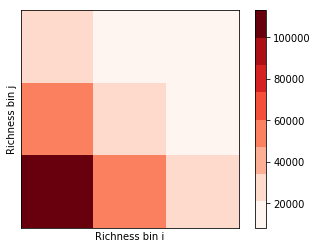

Covariance matrix fixing Z bins 3 and 10


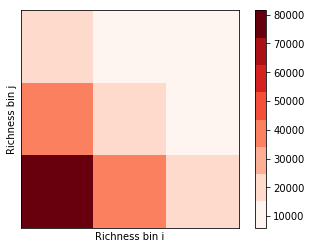

Covariance matrix fixing Z bins 3 and 11


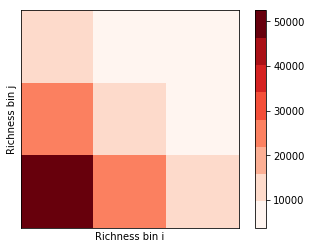

Covariance matrix fixing Z bins 3 and 12


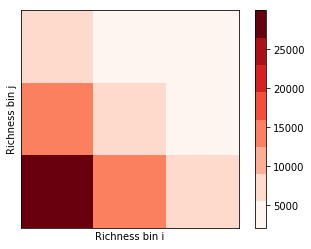

Covariance matrix fixing Z bins 3 and 13


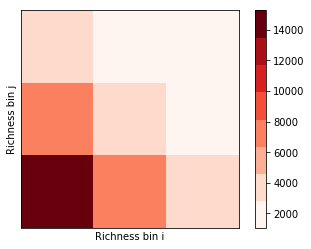

Covariance matrix fixing Z bins 3 and 14


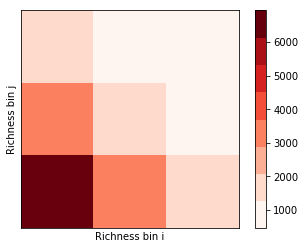

Covariance matrix fixing Z bins 3 and 15


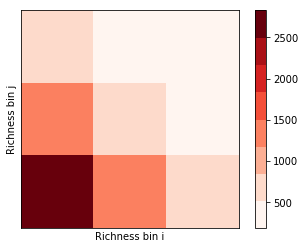

Covariance matrix fixing Z bins 3 and 16


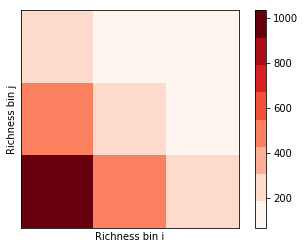

Covariance matrix fixing Z bins 3 and 17


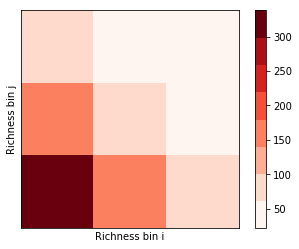

Covariance matrix fixing Z bins 4 and 4


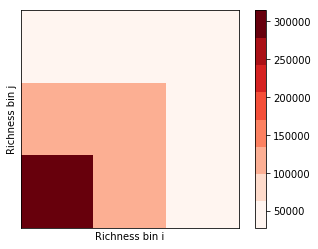

Covariance matrix fixing Z bins 4 and 5


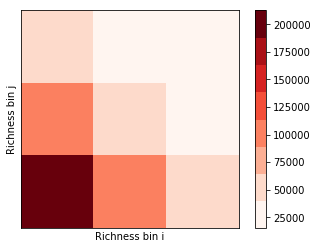

Covariance matrix fixing Z bins 4 and 6


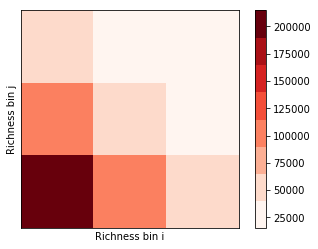

Covariance matrix fixing Z bins 4 and 7


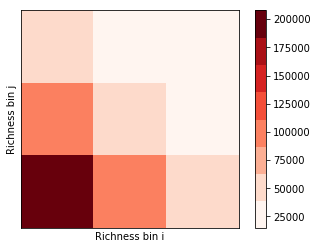

Covariance matrix fixing Z bins 4 and 8


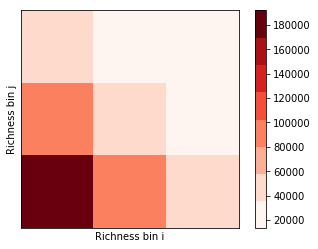

Covariance matrix fixing Z bins 4 and 9


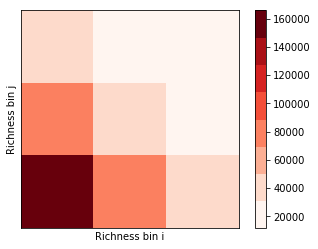

Covariance matrix fixing Z bins 4 and 10


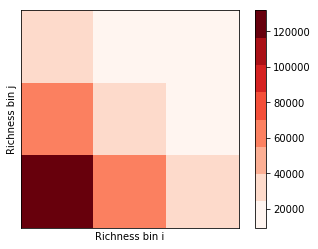

Covariance matrix fixing Z bins 4 and 11


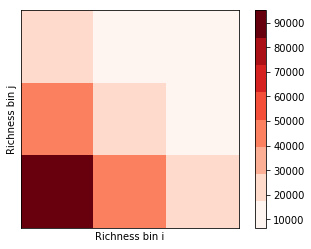

Covariance matrix fixing Z bins 4 and 12


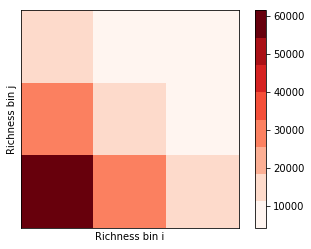

Covariance matrix fixing Z bins 4 and 13


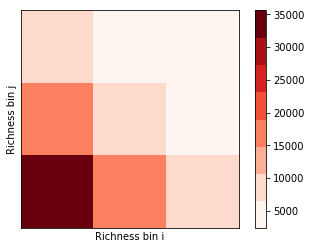

Covariance matrix fixing Z bins 4 and 14


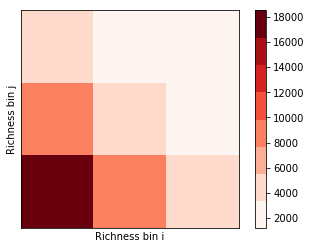

Covariance matrix fixing Z bins 4 and 15


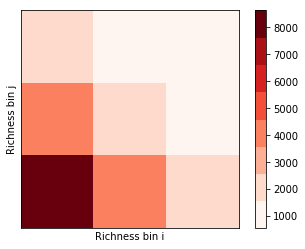

Covariance matrix fixing Z bins 4 and 16


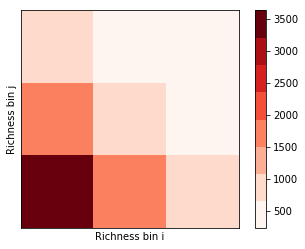

Covariance matrix fixing Z bins 4 and 17


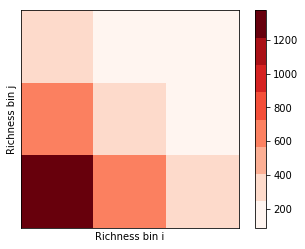

Covariance matrix fixing Z bins 5 and 5


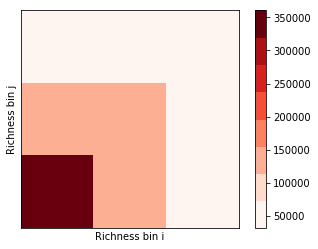

Covariance matrix fixing Z bins 5 and 6


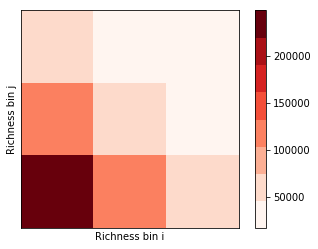

Covariance matrix fixing Z bins 5 and 7


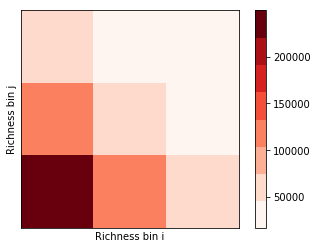

Covariance matrix fixing Z bins 5 and 8


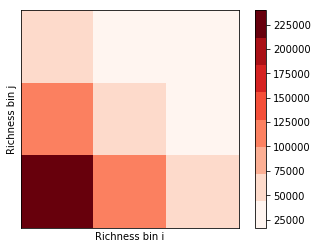

Covariance matrix fixing Z bins 5 and 9


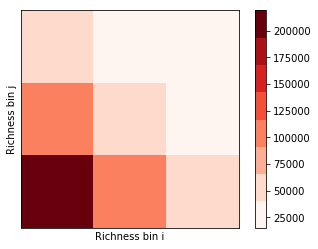

Covariance matrix fixing Z bins 5 and 10


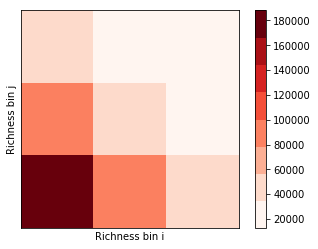

Covariance matrix fixing Z bins 5 and 11


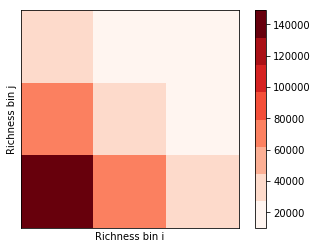

Covariance matrix fixing Z bins 5 and 12


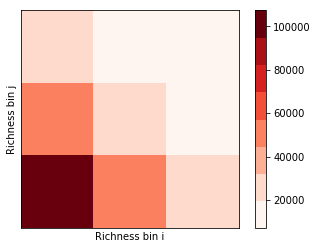

Covariance matrix fixing Z bins 5 and 13


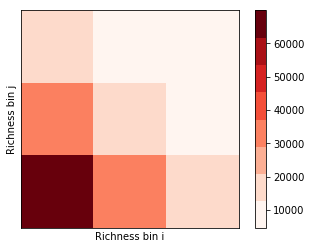

Covariance matrix fixing Z bins 5 and 14


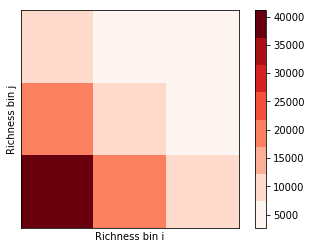

Covariance matrix fixing Z bins 5 and 15


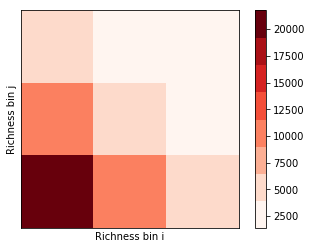

Covariance matrix fixing Z bins 5 and 16


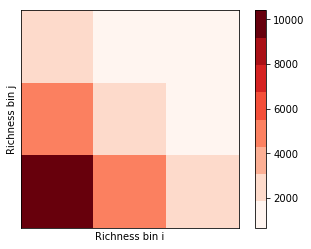

Covariance matrix fixing Z bins 5 and 17


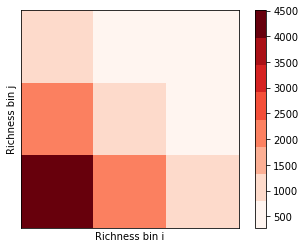

Covariance matrix fixing Z bins 6 and 6


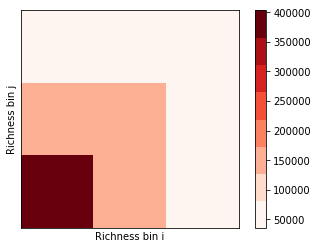

Covariance matrix fixing Z bins 6 and 7


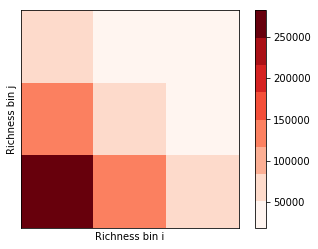

Covariance matrix fixing Z bins 6 and 8


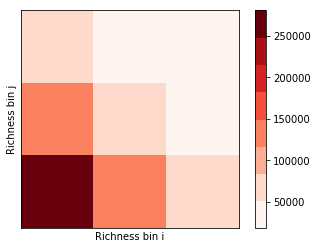

Covariance matrix fixing Z bins 6 and 9


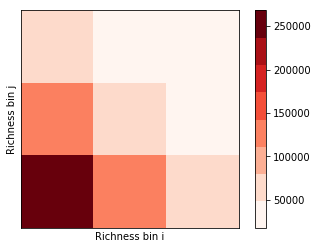

Covariance matrix fixing Z bins 6 and 10


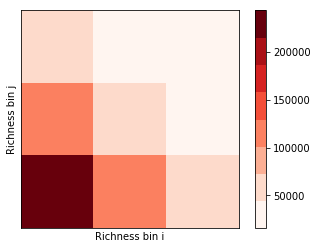

Covariance matrix fixing Z bins 6 and 11


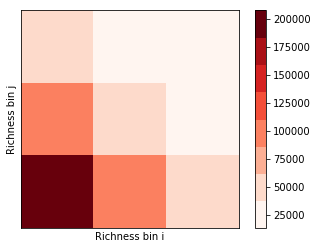

Covariance matrix fixing Z bins 6 and 12


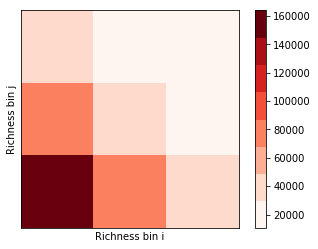

Covariance matrix fixing Z bins 6 and 13


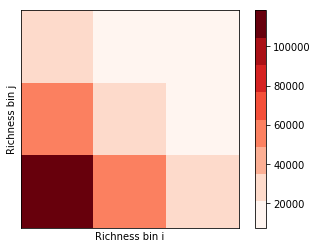

Covariance matrix fixing Z bins 6 and 14


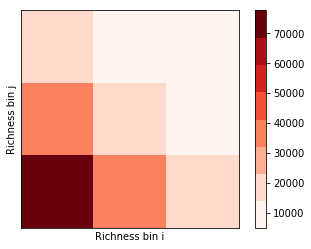

Covariance matrix fixing Z bins 6 and 15


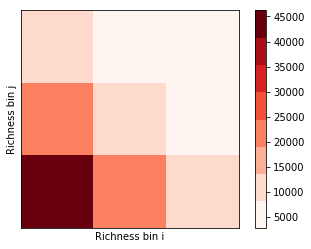

Covariance matrix fixing Z bins 6 and 16


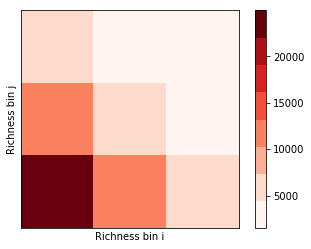

Covariance matrix fixing Z bins 6 and 17


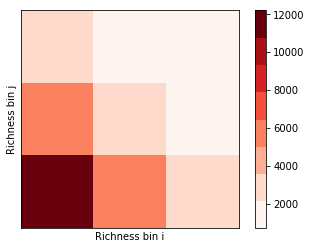

Covariance matrix fixing Z bins 7 and 7


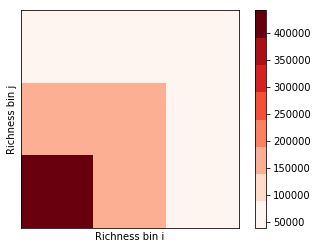

Covariance matrix fixing Z bins 7 and 8


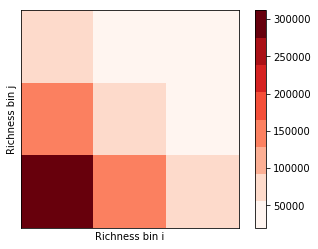

Covariance matrix fixing Z bins 7 and 9


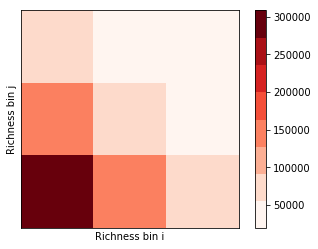

Covariance matrix fixing Z bins 7 and 10


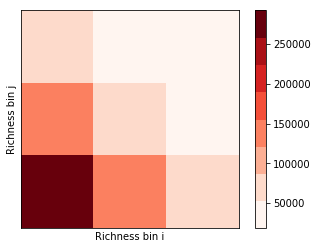

Covariance matrix fixing Z bins 7 and 11


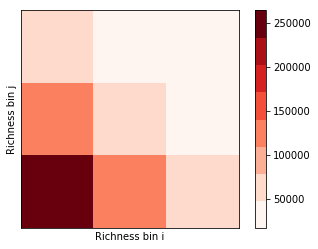

Covariance matrix fixing Z bins 7 and 12


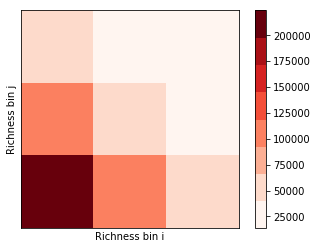

Covariance matrix fixing Z bins 7 and 13


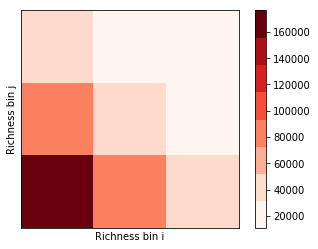

Covariance matrix fixing Z bins 7 and 14


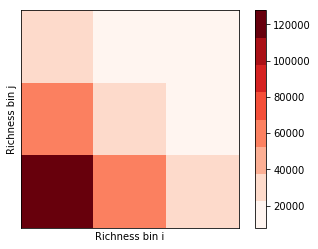

Covariance matrix fixing Z bins 7 and 15


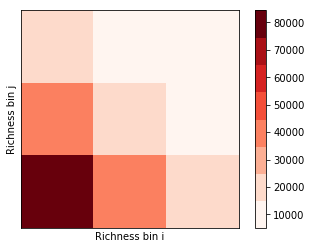

Covariance matrix fixing Z bins 7 and 16


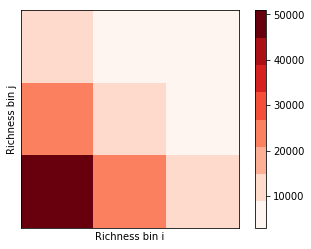

Covariance matrix fixing Z bins 7 and 17


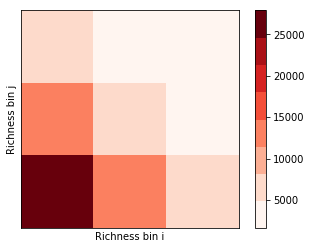

Covariance matrix fixing Z bins 8 and 8


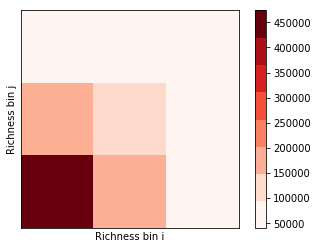

Covariance matrix fixing Z bins 8 and 9


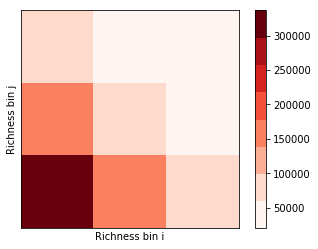

Covariance matrix fixing Z bins 8 and 10


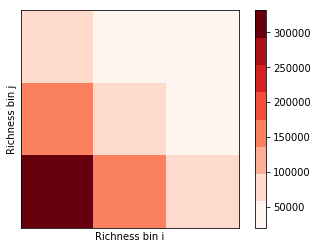

Covariance matrix fixing Z bins 8 and 11


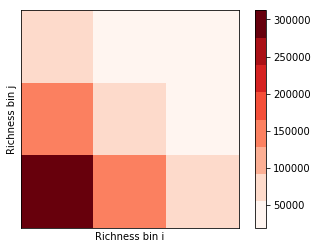

Covariance matrix fixing Z bins 8 and 12


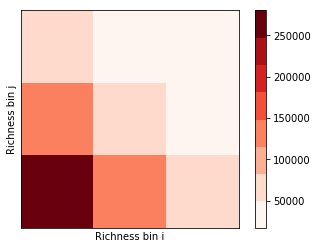

Covariance matrix fixing Z bins 8 and 13


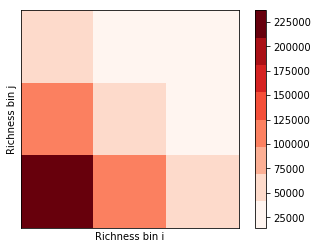

Covariance matrix fixing Z bins 8 and 14


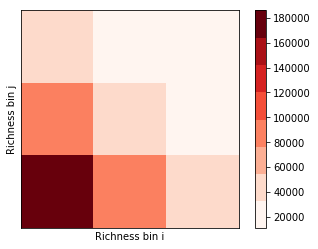

Covariance matrix fixing Z bins 8 and 15


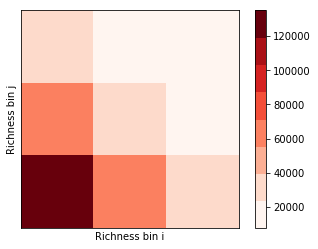

Covariance matrix fixing Z bins 8 and 16


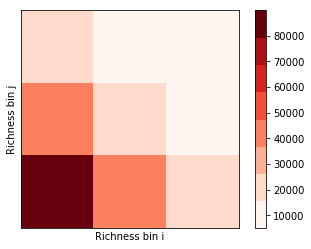

Covariance matrix fixing Z bins 8 and 17


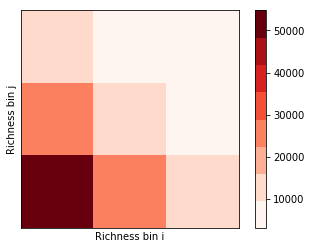

Covariance matrix fixing Z bins 9 and 9


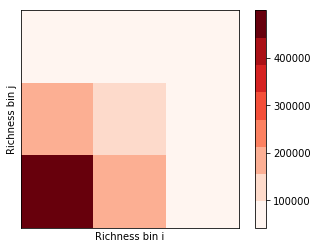

Covariance matrix fixing Z bins 9 and 10


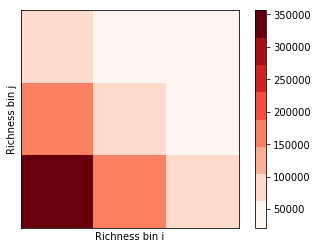

Covariance matrix fixing Z bins 9 and 11


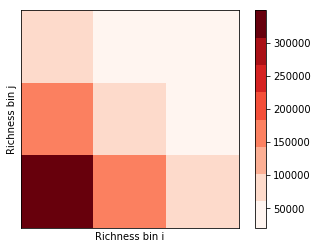

Covariance matrix fixing Z bins 9 and 12


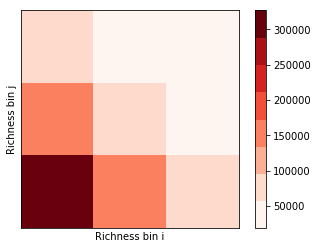

Covariance matrix fixing Z bins 9 and 13


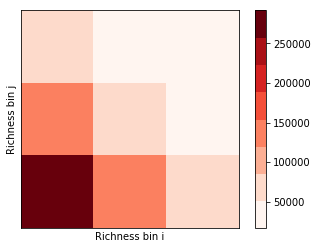

Covariance matrix fixing Z bins 9 and 14


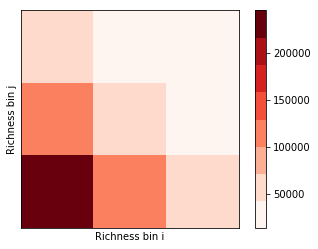

Covariance matrix fixing Z bins 9 and 15


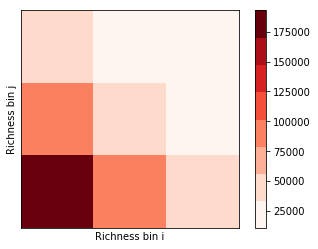

Covariance matrix fixing Z bins 9 and 16


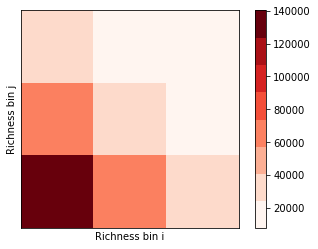

Covariance matrix fixing Z bins 9 and 17


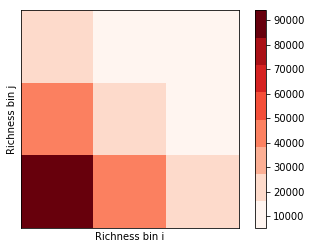

Covariance matrix fixing Z bins 10 and 10


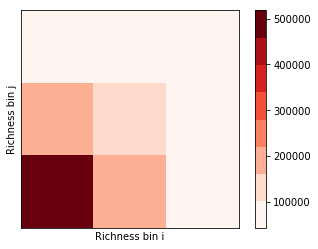

Covariance matrix fixing Z bins 10 and 11


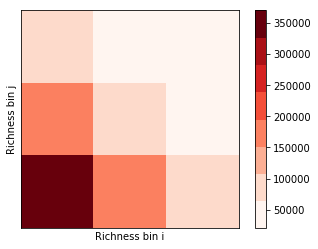

Covariance matrix fixing Z bins 10 and 12


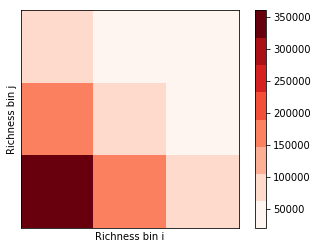

Covariance matrix fixing Z bins 10 and 13


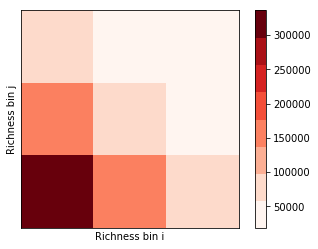

Covariance matrix fixing Z bins 10 and 14


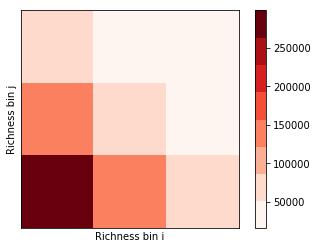

Covariance matrix fixing Z bins 10 and 15


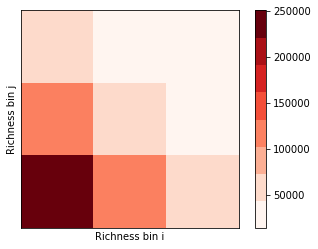

Covariance matrix fixing Z bins 10 and 16


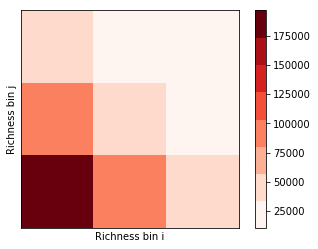

Covariance matrix fixing Z bins 10 and 17


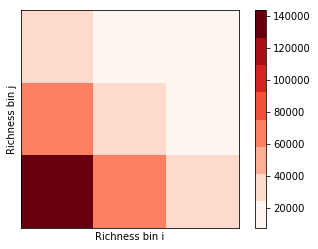

Covariance matrix fixing Z bins 11 and 11


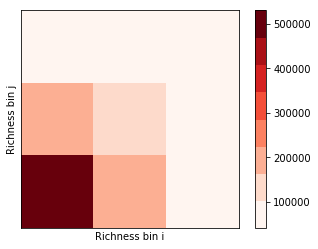

Covariance matrix fixing Z bins 11 and 12


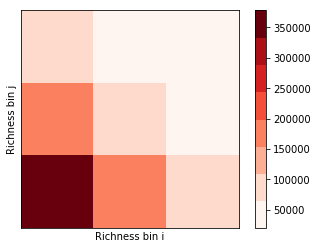

Covariance matrix fixing Z bins 11 and 13


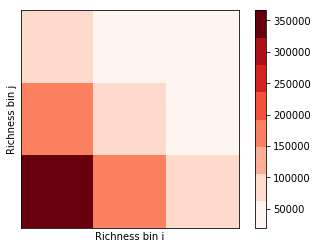

Covariance matrix fixing Z bins 11 and 14


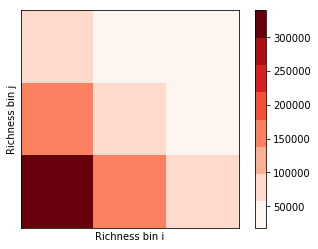

Covariance matrix fixing Z bins 11 and 15


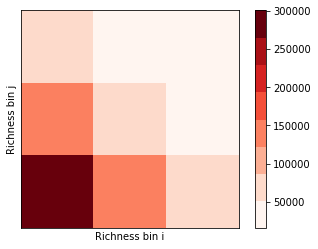

Covariance matrix fixing Z bins 11 and 16


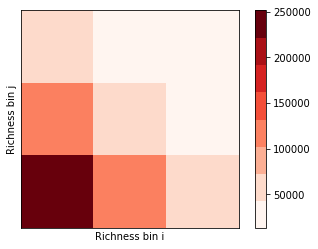

Covariance matrix fixing Z bins 11 and 17


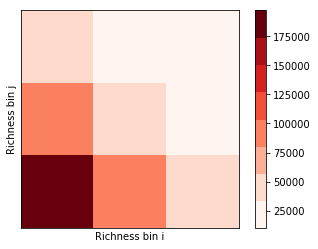

Covariance matrix fixing Z bins 12 and 12


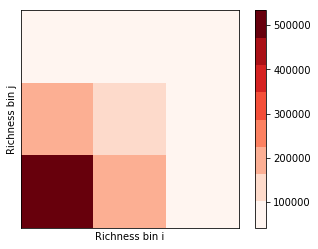

Covariance matrix fixing Z bins 12 and 13


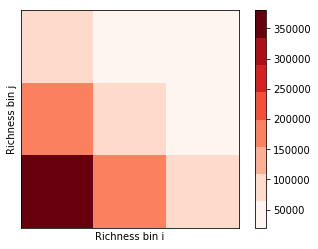

Covariance matrix fixing Z bins 12 and 14


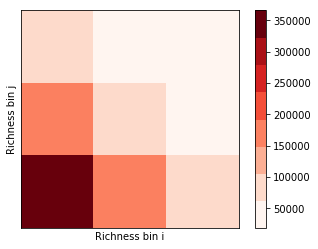

Covariance matrix fixing Z bins 12 and 15


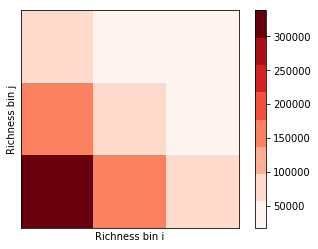

Covariance matrix fixing Z bins 12 and 16


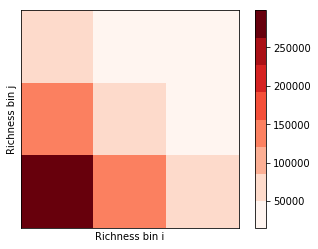

Covariance matrix fixing Z bins 12 and 17


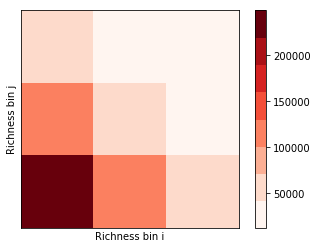

Covariance matrix fixing Z bins 13 and 13


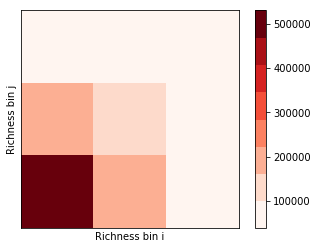

Covariance matrix fixing Z bins 13 and 14


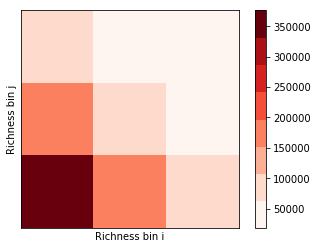

Covariance matrix fixing Z bins 13 and 15


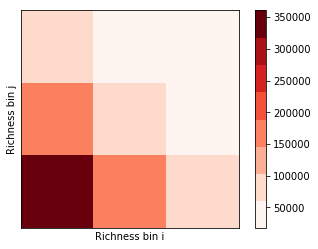

Covariance matrix fixing Z bins 13 and 16


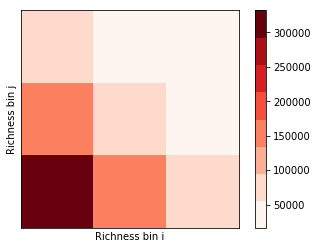

Covariance matrix fixing Z bins 13 and 17


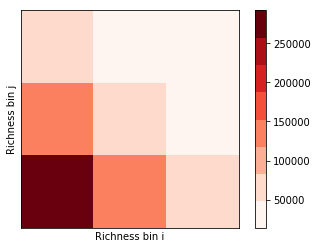

Covariance matrix fixing Z bins 14 and 14


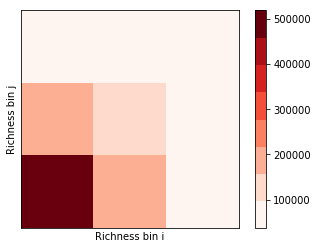

Covariance matrix fixing Z bins 14 and 15


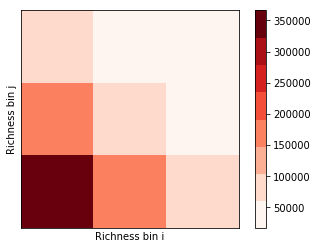

Covariance matrix fixing Z bins 14 and 16


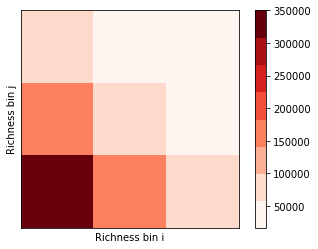

Covariance matrix fixing Z bins 14 and 17


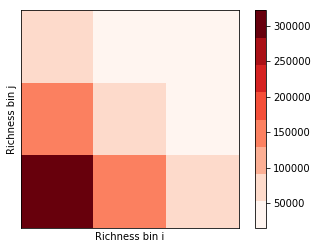

Covariance matrix fixing Z bins 15 and 15


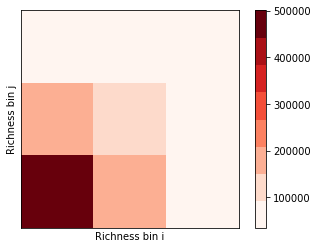

Covariance matrix fixing Z bins 15 and 16


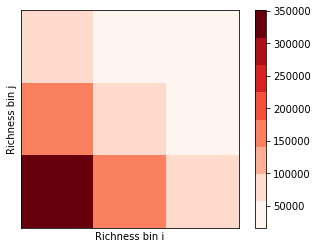

Covariance matrix fixing Z bins 15 and 17


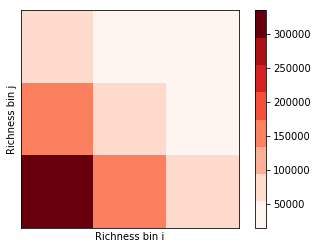

Covariance matrix fixing Z bins 16 and 16


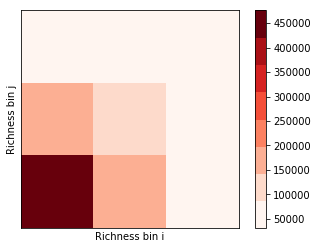

Covariance matrix fixing Z bins 16 and 17


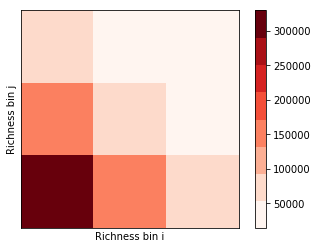

Covariance matrix fixing Z bins 17 and 17


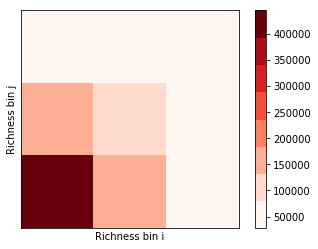

In [24]:
#Print results

for lbd_i in range(Num_Lbd_bins):
    for lbd_j in range(lbd_i, Num_Lbd_bins):
        print("Covariance matrix fixing Mass bins "+str(lbd_i)+" and " + str(lbd_j))
        plt.imshow(np.rot90(final_array[lbd_i,lbd_j,:,:]), cmap=plt.cm.get_cmap('Reds', 8))
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("Redshift bin i")
        plt.ylabel ("Redshift bin j")
        plt.show()
        
for z_i in range(Num_z_bins):
    for z_j in range(z_i, Num_z_bins):
        print("Covariance matrix fixing Z bins "+str(z_i)+" and " + str(z_j))
        plt.imshow(np.rot90(final_array[:,:,z_i,z_j]), cmap=plt.cm.get_cmap('Reds', 8))
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("Richness bin i")
        plt.ylabel ("Richness bin j")
        plt.show()




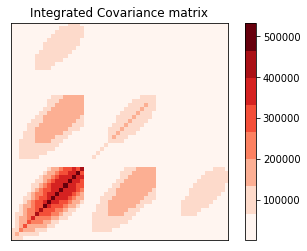

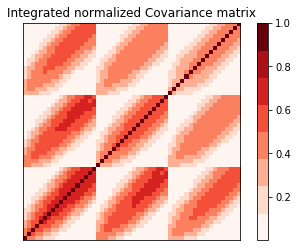

[[1.30404707e+05 7.29022440e+04 7.14422294e+04 ... 6.53284604e+00
  1.42174916e+00 2.65894182e-01]
 [7.29022440e+04 1.72972406e+05 1.03950310e+05 ... 4.10286316e+01
  1.07992551e+01 2.49135889e+00]
 [7.14422294e+04 1.03950310e+05 2.19173397e+05 ... 1.95548545e+02
  6.08832354e+01 1.68458056e+01]
 ...
 [6.53284604e+00 4.10286316e+01 1.95548545e+02 ... 4.11163785e+04
  1.58844165e+04 1.50485509e+04]
 [1.42174916e+00 1.07992551e+01 6.08832354e+01 ... 1.58844165e+04
  3.82497795e+04 1.42961288e+04]
 [2.65894182e-01 2.49135889e+00 1.68458056e+01 ... 1.50485509e+04
  1.42961288e+04 3.51800722e+04]]
[[1.00000000e+00 4.85406792e-01 4.22585357e-01 ... 8.92171533e-05
  2.01308392e-05 3.92567043e-06]
 [4.85406792e-01 1.00000000e+00 5.33879758e-01 ... 4.86509351e-04
  1.32767238e-04 3.19373969e-05]
 [4.22585357e-01 5.33879758e-01 1.00000000e+00 ... 2.05993370e-03
  6.64950529e-04 1.91844566e-04]
 ...
 [8.92171533e-05 4.86509351e-04 2.05993370e-03 ... 1.00000000e+00
  4.00543208e-01 3.95675256e-01]

In [25]:
#and now putting it all on the same consolidated matrix 
consolidated_matrix = np.zeros((Num_Lbd_bins*Num_z_bins, Num_Lbd_bins*Num_z_bins))
for row in range(Num_Lbd_bins*Num_z_bins):
    for column in range(row, Num_Lbd_bins*Num_z_bins):
        consolidated_matrix[row,column] = final_array[row//Num_z_bins, column//Num_z_bins,np.mod(row,Num_z_bins), np.mod(column, Num_z_bins)]
        consolidated_matrix[column,row] = consolidated_matrix[row,column]


norm_matrix = np.zeros((Num_Lbd_bins*Num_z_bins, Num_Lbd_bins*Num_z_bins))
for i in range(Num_Lbd_bins*Num_z_bins):
    for j in range (i, Num_Lbd_bins*Num_z_bins):
        norm_matrix[i][j] = consolidated_matrix[i][j]/np.sqrt(consolidated_matrix[i][i]*consolidated_matrix[j][j])
        norm_matrix[j][i] = norm_matrix[i][j]
        
plt.imshow(np.rot90(consolidated_matrix), cmap=plt.cm.get_cmap('Reds', 8))
plt.title("Integrated Covariance matrix")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(np.rot90(norm_matrix), cmap=plt.cm.get_cmap('Reds', 8))
plt.title("Integrated normalized Covariance matrix")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()
print(consolidated_matrix)
print(norm_matrix)

In [26]:
#Printing same matrices without shot noise diagonal terms
consolidated_no_noise = consolidated_matrix
for diag in range(Num_Lbd_bins*Num_z_bins):
    consolidated_no_noise[diag,diag] = consolidated_no_noise[diag,diag]-shot_noise(np.mod(diag, Num_z_bins),diag//Num_z_bins) 
       
        


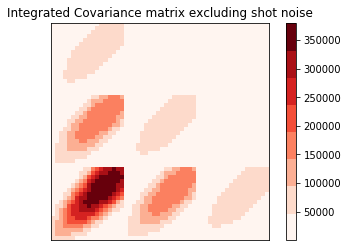

[ 20827.96756971  49369.24484535  91399.55882295 140989.33386189
 191812.40364953 239578.54631191 280790.54333473 311467.16055298
 328093.6855972  336591.87718069 331221.93023968 312306.62269258
 280217.91376541 236675.01028419 186079.70787962 134996.13033288
  89875.14941631  54771.1694031   11025.83942674  26024.85275187
  47922.82746455  73439.93928188  99158.29517888 122831.06266994
 142723.59374314 156929.9478443  163836.97319748 167887.01810141
 165017.52761741 155392.80761159 139200.71026308 117323.93493266
  92000.93392881  66535.76767002  44139.15045389  26793.59387646
   5849.70822105  13744.63339534  25163.7270406   38291.2750509
  51281.89960391  62964.96448352  72491.4014886   78964.35433629
  81662.2461254   83579.12881648  82050.25193895  77158.82153403
  68999.65202818  58025.89213621  45374.74807539  32706.52786314
  21615.32273863  13066.66809209]


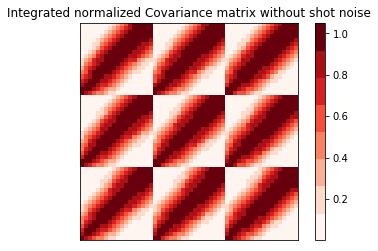

[0.14107843 0.27910951 0.44538189 0.60829239 0.74859487 0.86087344
 0.94306804 0.99071562 1.         0.99352154 0.95601242 0.88929206
 0.79375101 0.67239974 0.53475295 0.3959877  0.27168022 0.17237497
 0.13906166 0.27615546 0.44195375 0.60486269 0.74541623 0.8580948
 0.9409117  0.98946353 0.99985231 1.00247238 0.97365918 0.91424907
 0.82359316 0.70388414 0.56448052 0.42126529 0.29112305 0.18596192
 0.13687157 0.27293254 0.43819259 0.6010718  0.74186529 0.85493692
 0.93837679 0.98784952 0.9993767  1.01167452 0.99226927 0.94092441
 0.85582048 0.73818926 0.59713308 0.44923547 0.31278338 0.20119356]


In [27]:

norm_matrix_no_noise = np.zeros((Num_Lbd_bins*Num_z_bins, Num_Lbd_bins*Num_z_bins))
for i in range(Num_Lbd_bins*Num_z_bins):
    for j in range (i, Num_Lbd_bins*Num_z_bins):
        norm_matrix_no_noise[i][j] = consolidated_no_noise[i][j]/np.sqrt(consolidated_no_noise[i][i]*consolidated_no_noise[j][j])
        norm_matrix_no_noise[j][i] = norm_matrix_no_noise[i][j]

plt.imshow(np.rot90(consolidated_no_noise), cmap=plt.cm.get_cmap('Reds', 8))
plt.title("Integrated Covariance matrix excluding shot noise")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

print(consolidated_no_noise[8,:])

plt.imshow(np.rot90(norm_matrix_no_noise), cmap=plt.cm.get_cmap('Reds', 8))
plt.title("Integrated normalized Covariance matrix without shot noise")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

print(norm_matrix_no_noise[8,:])

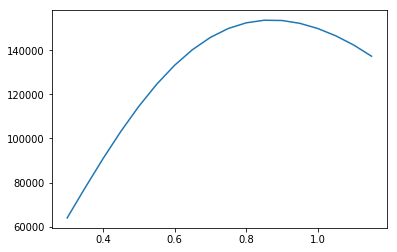

In [28]:
test_shot = np.array([shot_noise(i,0) for i in range(Num_z_bins)])
plt.plot(Z_bins[:-1],test_shot)
plt.show()

In [29]:
def dV_prime(z_true): #output will be in Mpc**3
    return c*(ccl.comoving_radial_distance(cosmo, 1/(1+z_true))**2)/(100*h0*ccl.h_over_h0(cosmo,1/(1+z_true)))

In [30]:
z_print = np.linspace(0.1,5,500)
dV_print = dV_prime(z_print)


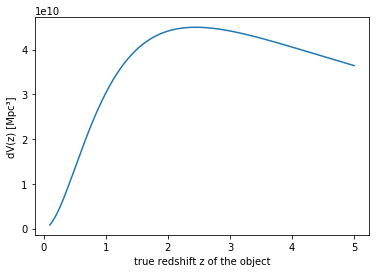

In [31]:
plt.plot(z_print,dV_print)
plt.xlabel("true redshift z of the object")
plt.ylabel("dV(z) [Mpc³]")
plt.show()